In [1]:
from lsst.daf.butler import Butler
from astropy.table import Table
import pylab
import numpy
from astropy.stats import mad_std
from tqdm import tqdm
from astropy.io import fits
import pandas as pd

In [2]:
repo_path = "/repo/ir2"
butler = Butler(repo_path,instrument='LSSTCam')
registry = butler.registry

We query what collections we have in the repository

In [31]:
#13590
#13535
#13525
# https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=405094202
collections = list(registry.queryCollections("*stability*13535*"))
collections

['u/lsstccs/eo_flat_gain_stability_13535_w_2023_41/20231112T062559Z',
 'u/lsstccs/eo_flat_gain_stability_13535_w_2023_41']

We query what dataset are in this collections

In [32]:
list(registry.getCollectionSummary(collections[0]).dataset_types)

[DatasetType('flatGainStabilityTask_log', {instrument, detector}, ButlerLogRecords),
 DatasetType('flat_gain_stability_stats', {instrument, detector}, DataFrame),
 DatasetType('flatGainStabilityTask_metadata', {instrument, detector}, TaskMetadata),
 DatasetType('flatGainStabilityPlots_metadata', {instrument}, TaskMetadata),
 DatasetType('flatGainStabilityTask_config', {}, Config),
 DatasetType('flat_gain_stability_plots', {instrument}, Plot),
 DatasetType('flatGainStabilityPlots_config', {}, Config),
 DatasetType('packages', {}, Packages),
 DatasetType('flatGainStabilityPlots_log', {instrument}, ButlerLogRecords)]

We convert the sensor address to the DM numbering

In [33]:
sensor="R23_S00"
detector=list(registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id
detector

99

Obtain flat stability statistics given the sensor

In [34]:
df=butler.get('flat_gain_stability_stats',collections=collections,detector=detector)
df

,raft,slot,exposure,pd_integral,mjd,amp_name,median,stdev_clip
0,R23,S00,2023111001321,0.000002,60259.222765,C10,14685.433594,121.013648
1,R23,S00,2023111001321,0.000002,60259.222765,C11,14696.310547,136.417904
2,R23,S00,2023111001321,0.000002,60259.222765,C12,14790.843750,121.775901
3,R23,S00,2023111001321,0.000002,60259.222765,C13,14686.334961,120.946175
4,R23,S00,2023111001321,0.000002,60259.222765,C14,14729.735352,122.612289
...,...,...,...,...,...,...,...,...
17755,R23,S00,2023111100813,0.000002,60260.262762,C04,14188.246094,115.222155
17756,R23,S00,2023111100813,0.000002,60260.262762,C03,14163.139648,115.512521
17757,R23,S00,2023111100813,0.000002,60260.262762,C02,14160.588867,114.472667
17758,R23,S00,2023111100813,0.000002,60260.262762,C01,14161.702148,114.539916


Specify temp key

In [35]:
TEMPKEY='TEMP6'

In [ ]:
Retrieve temperature more efficient than 

In [36]:
expids=set(list(df['exposure']))

fsspec_kwargs = {
    "default_block_size": 100000,
    "default_cache_type": "bytes",
    "endpoint_url": "https://s3dfrgw.slac.stanford.edu"
}

temps=[]
expid=[]
for ref in tqdm(sorted( expids )[::10]):
    try:

        with fits.open(
            butler.getURI('raw',dataId={"exposure": ref},
            collections=collections,detector=detector).geturl(),
            use_fsspec=True,
            fsspec_kwargs = fsspec_kwargs
             ) as fh:            
            expid.append(ref)
            temps.append(fh[-2].header[TEMPKEY])

    except:
        pass

100%|██████████| 111/111 [01:41<00:00,  1.10it/s]


In [40]:
dfmerged=pd.merge(df, pd.DataFrame({'exposure': expid, TEMPKEY: temps }), on='exposure', how='inner')

In [41]:
subset=dfmerged[dfmerged['amp_name']=='C00']

Text(0, 0.5, 'median/pd_integral')

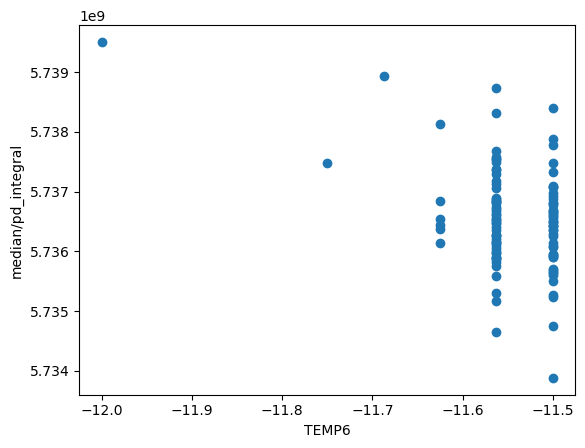

In [42]:
pylab.scatter(subset[TEMPKEY],subset['median']/subset['pd_integral'])
pylab.xlabel(TEMPKEY)
pylab.ylabel('median/pd_integral')